<a href="https://colab.research.google.com/github/ogunjosam/ISIMIP_data/blob/main/Extract_onset_locations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract point locations for onset and cessation 

In [ ]:
import pandas as pd
import glob
from netCDF4 import Dataset
import netCDF4
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pymannkendall

import pymannkendall as mk

Function to do some magic

In [ ]:
def index_locator(data,cord):
    cor_lat = data
    latbounds = cord
    cor_lat = pd.DataFrame(cor_lat)
    #print([latbounds])
    cor_lat2 = pd.DataFrame({'a':cor_lat.iloc[:,0], 'b':abs(cor_lat.iloc[:,0] - latbounds)})
    a = cor_lat2[cor_lat2.b == min(cor_lat2.b)].first_valid_index()
    
    return a

Let's do the extraction in a loop

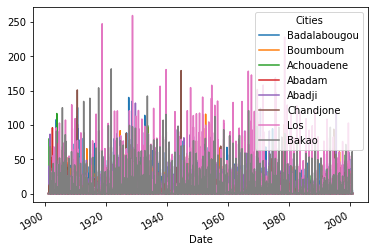

In [21]:
lk = 'https://raw.githubusercontent.com/ogunjosam/ISIMIP_data/main/Sahel_cities_Conference.csv'
loc = pd.read_csv(lk)
xlat = loc['Lat']
xlon = loc['Lon']

ydata = pd.DataFrame(columns=loc['Cities'])
tdata = pd.DataFrame()

for yr in range(1901,2000,10):

  url  = f'http://esg.pik-potsdam.de/thredds/fileServer/isimip_dataroot/isimip2a/input/clim_atm_obs/GSWP3/historical/pr/daily/v20180927/pr_gswp3_{yr}_{yr+9}.nc'
  print(url)

  savename = url.split('/')[-1]

  urllib.request.urlretrieve(url, savename)

  nc_fid = Dataset(savename, 'r')
  lat = nc_fid.variables['lat'][:].data
  lon = nc_fid.variables['lon'][:].data
  time_var = nc_fid.variables['time']
  dtime = netCDF4.num2date(time_var[:],time_var.units,
                         only_use_cftime_datetimes=False,
                         only_use_python_datetimes=True)
  dates_pd = pd.Series(dtime)
  tdata = pd.concat([tdata,dates_pd],axis=0)
  
  f = 0
  xdata = pd.DataFrame(columns=loc['Cities'])
  for jj,j in enumerate(loc['Cities']):
    lat_index = index_locator(lat,xlat[jj])
    lon_index = index_locator(lon,xlon[jj])
    dd = nc_fid.variables['pr'][:,lat_index,lon_index].data
    xdata[j] = dd*86400
    f = f + 1
  
  ydata = pd.concat([ydata,xdata],axis=0)
ydata['Date'] = tdata
ydata = ydata.set_index("Date")
ydata.to_excel('merged_data.xlsx')
ydata.plot()

Just a few functions 

In [57]:
def dailyClim(x):

    daily_clim = np.copy(x)
    daily_clim.shape = (int(len(x) / 365), 365)
    daily_clim = np.apply_along_axis(np.mean, 0, daily_clim)

    return daily_clim

def getDate(x, i_wet_i, f_wet_i, wInd, R_ave):

    i_wet = int(np.where(i_wet_i - wInd < 0, 0, i_wet_i - wInd))
    f_wet = int(np.where(f_wet_i + wInd > 365, 365, f_wet_i + wInd))
    d_year = np.cumsum(x[i_wet:f_wet] - R_ave)
    if d_year.size > 0:
      onset_year = np.argmin(d_year)
      
      cessation_year = np.argmax(d_year)
    else:
      onset_year = 0
      cessation_year = 0


    return [onset_year, cessation_year]

'''
def getDate(x, i_wet_i, f_wet_i, wInd, R_ave):

    i_wet = int(np.where(i_wet_i - wInd < 0, 0, i_wet_i - wInd))
    f_wet = int(np.where(f_wet_i + wInd > 365, 365, f_wet_i + wInd))
    d_year = np.cumsum(x[i_wet:f_wet] - R_ave)
    onset_year = np.nan if np.isnan(d_year).any() else np.argmin(d_year)
    cessation_year = np.nan if np.isnan(d_year).any() else np.argmax(d_year)

    return [onset_year, cessation_year]
'''
def getOnsetCessation(x, wInd=45):

    ## daily climatology
    daily_clim = dailyClim(x)

    ## climatology onset and cessation dates
    R_ave = np.mean(daily_clim)
    d = np.cumsum(daily_clim - R_ave)
    i_wet_clim = np.argmin(d)
    f_wet_clim = np.argmax(d)

    ## getting onset and cessation dates by hydrological year
    wet_periods = np.split(x, len(x)/365)
    wet_periods = list(map(lambda y: getDate(y, i_wet_i=i_wet_clim,
                                             f_wet_i=f_wet_clim,
                                             wInd=wInd,
                                             R_ave=R_ave),
                           wet_periods))

    return np.concatenate(wet_periods, axis=0) + np.repeat(np.arange(0, len(x), 365), 2)

Estimate the onset and cessation dates

In [111]:


ydata.index = pd.to_datetime(ydata.index)
onset_data = pd.DataFrame(columns=loc['Cities'])
reces_data = pd.DataFrame(columns=loc['Cities'])
length_data = pd.DataFrame(columns=loc['Cities'])
prcp_data = pd.DataFrame(columns=loc['Cities'])
ydata = ydata[~ydata.index.strftime('%m-%d').isin(["02-29"])]

pp = np.arange(0,100)*365
for i, ii in enumerate(list(ydata)):
  
  OC = getOnsetCessation(x=ydata[ii])
  OC_dates = ydata.index[OC]

  to_map_x = OC[np.arange(0, len(OC), 2)] - pp
  onset_data[ii] = to_map_x
  
  to_map_y = OC[np.arange(1, len(OC), 2)] - pp
  reces_data[ii] = to_map_y

  lengthOC = [y - x for x, y in zip(to_map_x, to_map_y)]
  length_data[ii] = lengthOC

  PRCPTOT = [np.sum(ydata[ii][x:y]) for x, y in zip(OC[np.arange(0, len(OC), 2)], OC[np.arange(1, len(OC), 2)])]
  prcp_data[ii] = PRCPTOT


Lets get some plots out

[0, 'Badalabougou', 0.068, False, 0.012, False]
[1, 'Boumboum', 0.005, False, 0.013, False]
[2, 'Achouadene', -0.013, False, -0.043, False]
[3, 'Abadam', 0.0, False, 0.0, False]
[4, 'Abadji', -0.06, False, 0.031, False]
[5, 'Chandjone', -0.034, False, 0.0, False]
[6, 'Los', 0.154, True, -0.051, False]
[7, 'Bakao', 0.188, True, 0.0, False]


Cities,Badalabougou,Boumboum,Achouadene,Abadam,Abadji,Chandjone,Los,Bakao,Year
Year,,,,,,,,,
1901,38.0,45.0,54.0,35.0,21.0,6.0,34.0,38.0,1901
1902,43.0,54.0,2.0,0.0,28.0,55.0,54.0,64.0,1902
1903,47.0,9.0,9.0,53.0,62.0,85.0,71.0,75.0,1903
1904,34.0,48.0,0.0,51.0,83.0,53.0,58.0,36.0,1904
1905,42.0,32.0,34.0,10.0,34.0,21.0,54.0,58.0,1905
...,...,...,...,...,...,...,...,...,...
1996,42.0,71.0,51.0,32.0,44.0,31.0,39.0,53.0,1996
1997,67.0,46.0,54.0,35.0,55.0,43.0,79.0,82.0,1997
1998,60.0,26.0,57.0,48.0,45.0,54.0,63.0,73.0,1998


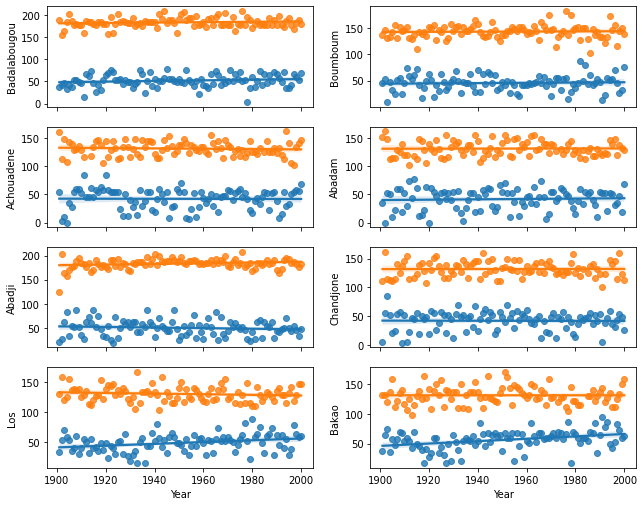

In [146]:
fig,axes = plt.subplots(4,2, figsize=(9,7),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=2)
axf = axes.flatten()


reces_data = reces_data.replace(0,np.nan)
#onset_data = onset_data.where(onset_data > 100,100)
onset_data['Year'] = np.arange(1901,2001)
reces_data['Year'] = np.arange(1901,2001)
for i, ii in enumerate(list(onset_data)[:-1]):
  onset_data.loc[onset_data[ii] > 100, ii] = onset_data[ii].mean()
  sns.regplot(x='Year',y=ii,data=onset_data,ax=axf[i])
  gu = mk.original_test(onset_data[ii],alpha=0.05)
  ku = mk.original_test(reces_data[ii].dropna(),alpha=0.05)
  print([i,ii,round(gu.slope,3),gu.h,round(ku.slope,3),ku.h])
  sns.regplot(x='Year',y=ii,data=reces_data,ax=axf[i])
  if i <6:
    axf[i].set_xlabel('')
  axf[i].set_ylabel(ii)

onset_data

Another set of plots

[0, 'Badalabougou', -0.19078754549269922, False]
[1, 'Boumboum', 0.0, False]
[2, 'Achouadene', 0.0, False]
[3, 'Abadam', 0.0, False]
[4, 'Abadji', 0.08949925630840577, False]
[5, 'Chandjone', 0.0, True]
[6, 'Los', 0.0, False]
[7, 'Bakao', 0.0, False]


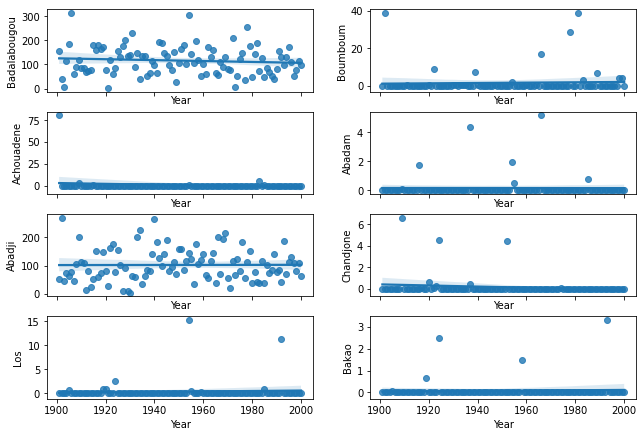

In [41]:
fig,axes = plt.subplots(4,2, figsize=(9,6),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=2)
axf = axes.flatten()

prcp_data['Year'] = np.arange(1901,2001)
for i, ii in enumerate(list(prcp_data)[:-1]):

  sns.regplot(x='Year',y=ii,data=prcp_data,ax=axf[i])
  gu = mk.original_test(prcp_data[ii],alpha=0.05)
  print([i,ii,gu.slope,gu.h])

Let's try decadal trends

Text(0.5, 42.0, 'Year')

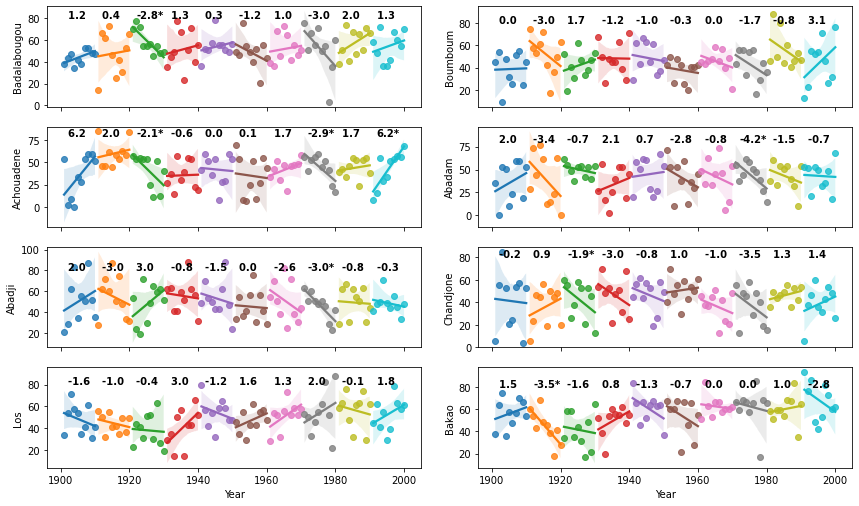

In [144]:
import warnings

warnings.filterwarnings("ignore")


#onset_data = onset_data.set_index('Year')

fig,axes = plt.subplots(4,2, figsize=(12,7),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=2)
axf = axes.flatten()

for m,mm in enumerate(np.arange(1901,2000,10)):
  
  vy_dum = onset_data[onset_data.index.isin(np.arange(mm,mm+10))]
  
  txt = [85,65,45]
  for v,vv in enumerate(list(vy_dum)):
    gu = mk.original_test(vy_dum[vv].dropna(),alpha=0.05)
    vy_dum['Year'] = vy_dum.index
    sns.regplot(x='Year',y=vv,data=vy_dum,ax=axf[v])

    if gu.p > 0.1:
      sig = ' '
    elif (gu.p < 0.1) & (gu.p >0.5):
      sig = '**'
    else:
      sig = '*'

    axf[v].set_xlabel('')
    
    axf[v].text(mm+1,80,str(np.round(gu.slope,1))+sig,fontweight='bold')
    


gu
axf[6].set_xlabel('Year')
axf[7].set_xlabel('Year')

Decadal trend for recession

Text(0.5, 42.0, 'Year')

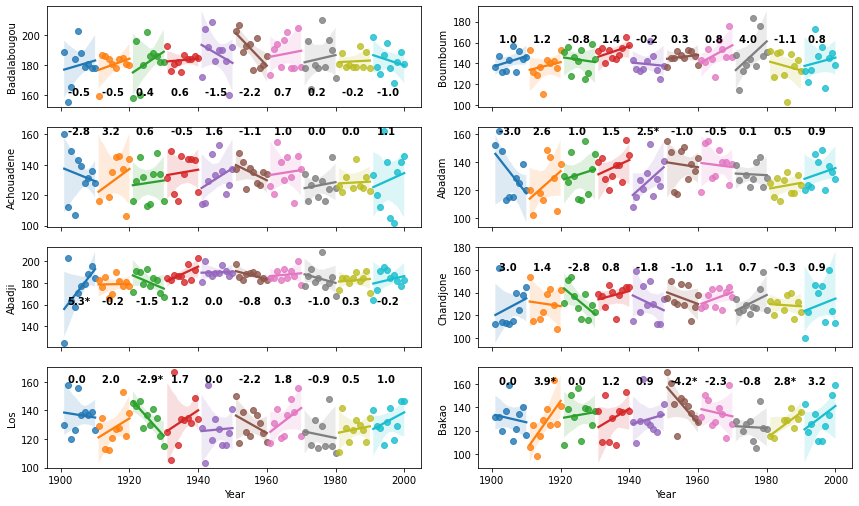

In [147]:
import warnings

warnings.filterwarnings("ignore")


reces_data = reces_data.set_index('Year')

fig,axes = plt.subplots(4,2, figsize=(12,7),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=2)
axf = axes.flatten()

for m,mm in enumerate(np.arange(1901,2000,10)):
  
  vy_dum = reces_data[reces_data.index.isin(np.arange(mm,mm+10))]
  
  
  for v,vv in enumerate(list(vy_dum)):
    
    gu = mk.original_test(vy_dum[vv].dropna(),alpha=0.05)
    vy_dum['Year'] = vy_dum.index
    sns.regplot(x='Year',y=vv,data=vy_dum,ax=axf[v])

    if gu.p > 0.1:
      sig = ' '
    elif (gu.p < 0.1) & (gu.p >0.5):
      sig = '**'
    else:
      sig = '*'

    
    axf[v].set_xlabel('')
    
    axf[v].text(mm+1,160,str(np.round(gu.slope,1))+sig,fontweight='bold')
    


gu
axf[6].set_xlabel('Year')
axf[7].set_xlabel('Year')